# Exploratory data analysis on the fraudulent credit card data.

The goal is to compare auto-encoder algorithm with some boosting methods like XGBoost, CatBoost, LightGBM, Random forest and other unsupervised learnign methods.

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

Read in the data

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
creditcard = pd.read_csv("creditcard.csv")

Need to split the data into three parts: train/dev/test

In [3]:
X = creditcard.drop(columns = ["Class"])
y = creditcard["Class"]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

Data preview

In [6]:
X_train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
272615,165180.0,-3.017333,3.215950,-2.844590,-1.341856,-0.491730,-1.776197,0.071360,1.470371,0.070087,...,0.338884,0.258544,0.843397,0.086503,0.026228,0.082502,0.112516,0.618475,0.454782,0.77
191231,129171.0,2.099809,-0.890100,-2.817319,-1.208673,0.845043,0.138699,0.064751,-0.009282,-0.974776,...,-0.196549,0.567082,1.621804,-0.242970,-1.581675,0.522156,0.415164,-0.070427,-0.118390,48.00
53595,46061.0,0.812352,-0.586909,-0.667514,0.962864,0.401248,0.721682,0.343162,0.121239,0.059051,...,0.259607,0.084476,-0.144437,-0.487009,-1.312940,0.806243,-0.202556,-0.027304,0.024049,230.57
193549,130180.0,-2.621263,-4.439432,-2.595440,-1.117193,2.489633,-2.625322,1.207772,-0.457577,-1.353822,...,2.078601,1.265437,1.872310,1.862566,0.615607,-0.594514,-0.172620,0.199639,0.485647,588.15
207723,136809.0,2.227359,-1.572316,-0.371772,-1.578679,-1.593467,-0.157863,-1.598295,0.004422,-1.074622,...,-0.362887,0.089499,0.852866,0.098889,-0.305689,-0.178513,0.009100,0.045008,-0.053145,19.98


It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, kaggle cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

## Any missing data?

In [7]:
X_train.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
dtype: int64

In [8]:
y_train.isnull().sum()

0

Perfect dataset with no missing value.

Combine the X_train and y_train for visualization purpose

In [9]:
creditcard = pd.concat([X_train,y_train], axis =1)

## Visualize the data

Let us just visualize the relationship of Time, Amount, V1 and V2 with Class column. 

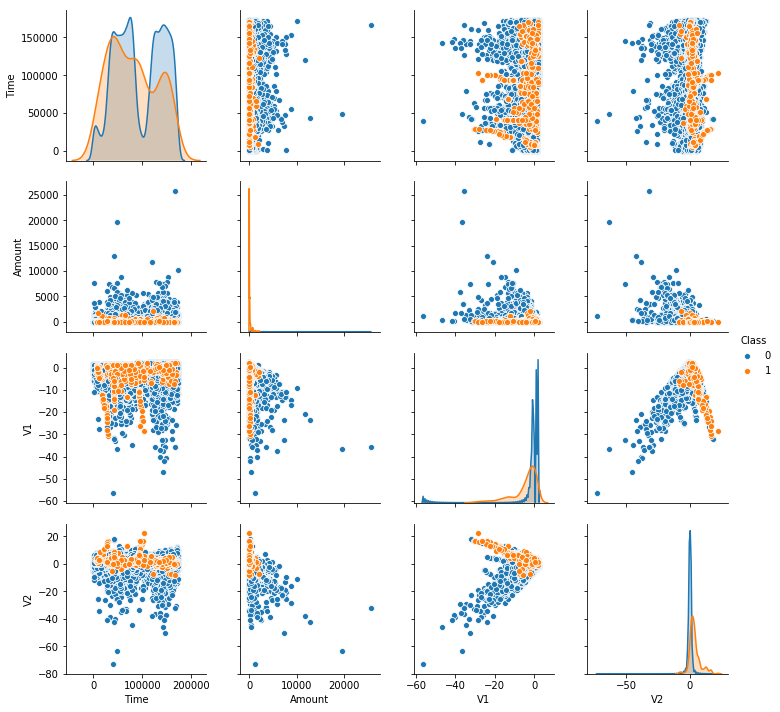

In [10]:
sns.pairplot(creditcard,vars =["Time","Amount","V1","V2"], hue = "Class")

The Time and Amount columns definitely have some relationship with fraudulent or not. Before we dive into model training, let us look at the histogram for each variable t ose if there is any outliers that needs to be taken care of. 

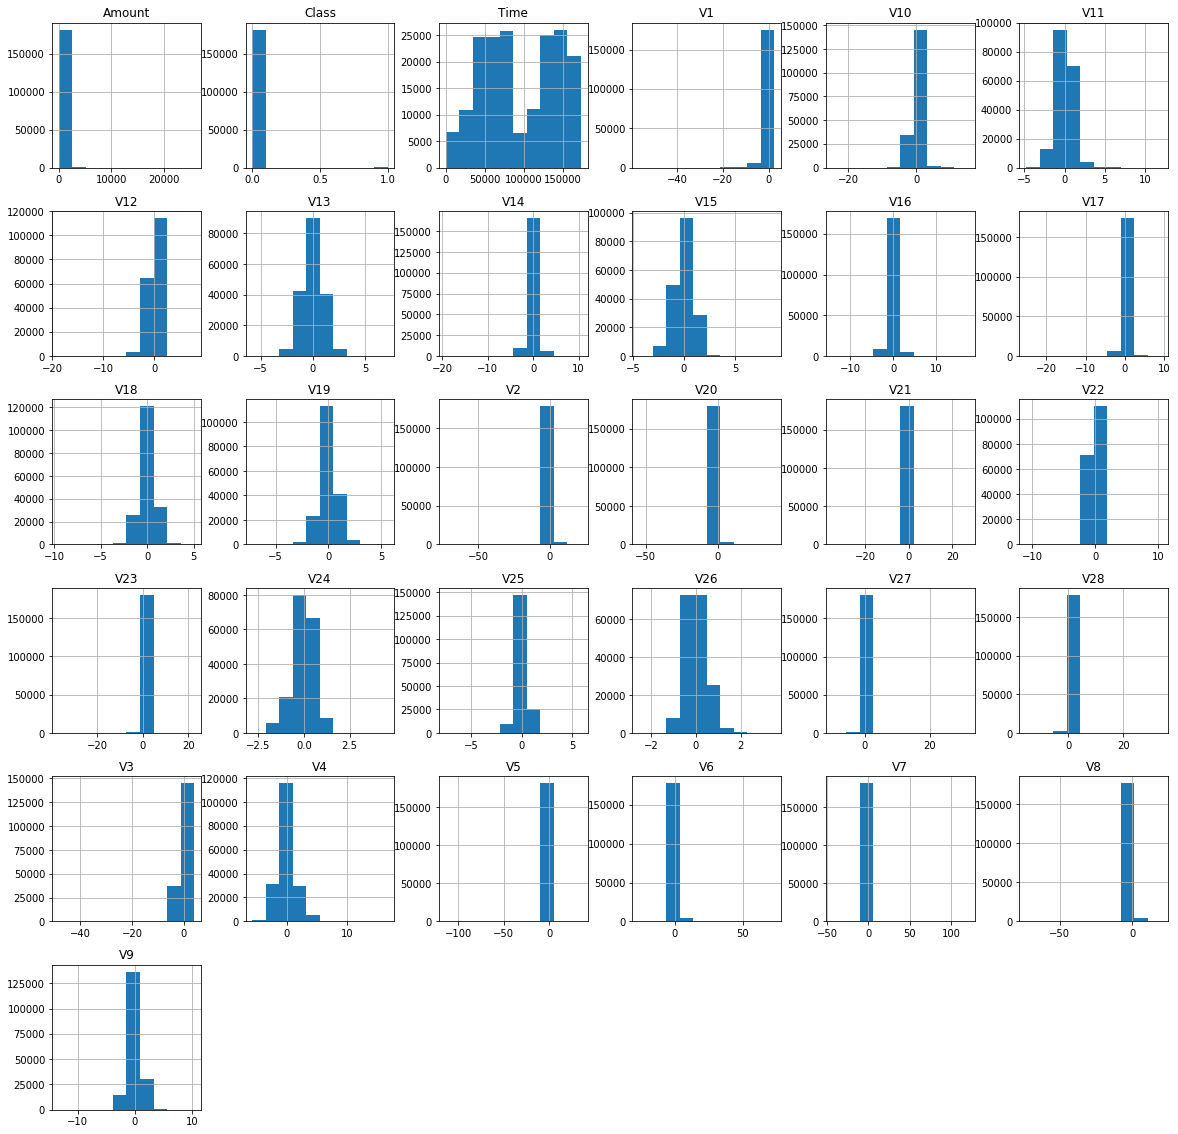

In [11]:
all_histgram = creditcard.hist(figsize = (20,20))

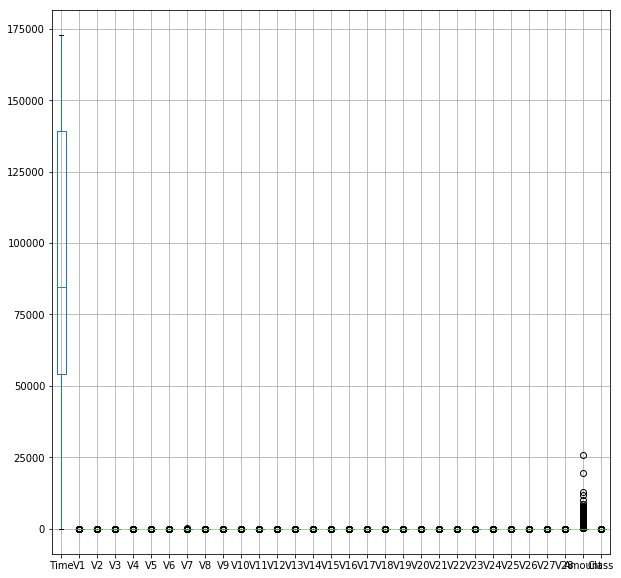

In [12]:
all_boxplot = creditcard.boxplot(figsize=(10, 10))

Both the Time and Amount variable seem particular large. In order to visualize and furthur model building, we should center and scale the features. 

In [13]:
all_scaler = StandardScaler().fit(X_train[X_train.columns])
Scaled_X_train = all_scaler.transform(X_train)

In [14]:
Scaled_X_train_df = pd.DataFrame(Scaled_X_train, index= X_train.index, columns= X_train.columns)

In [15]:
creditcard_scaled = pd.concat([Scaled_X_train_df,y_train], axis = 1)

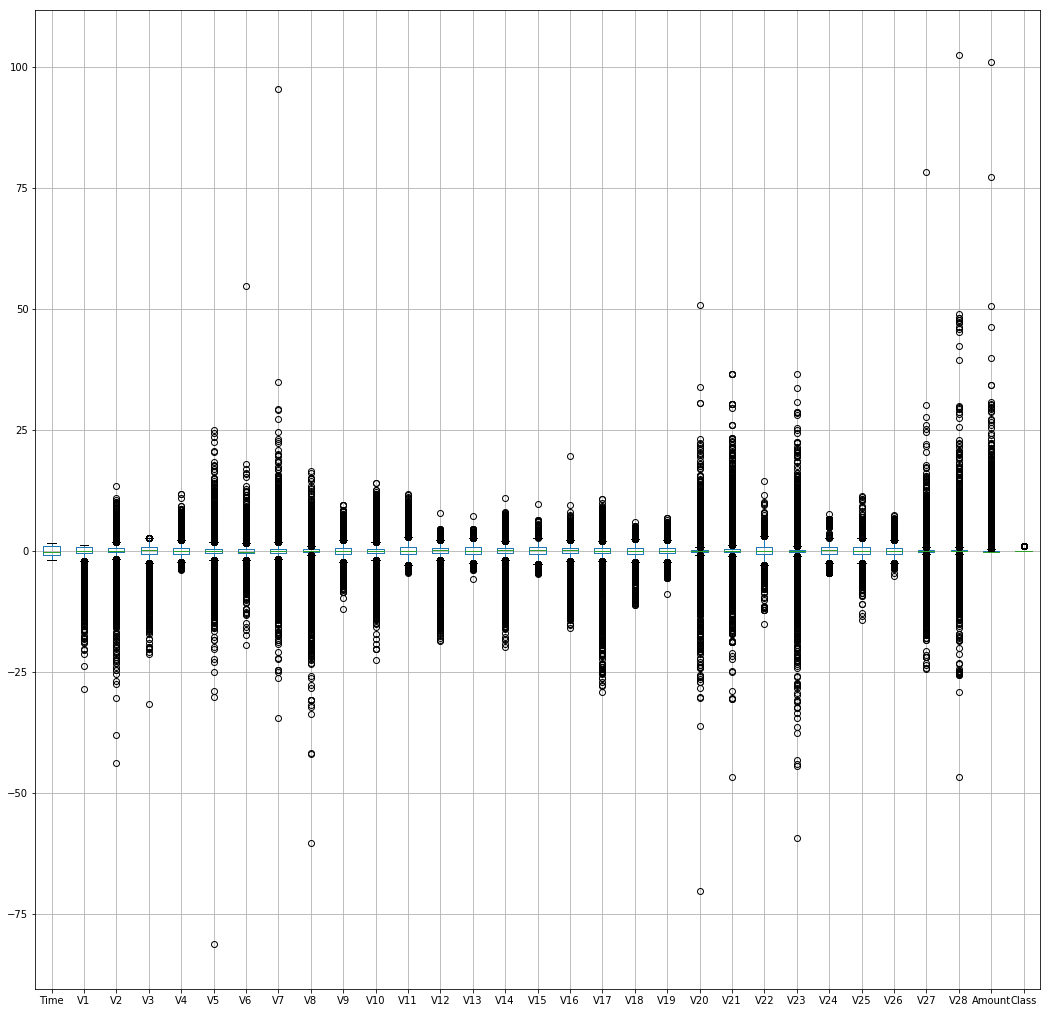

In [18]:
creditcard_scaled.boxplot(figsize = (18, 18))

It seems that all variables have some outliers. 

## How imbalanced is the dataset?

In [21]:
creditcard['Class'].value_counts()

0    181946
1       330
Name: Class, dtype: int64

This is extremely imbalanced dataset, and we do not expect any algorithms to perform super well on the precision for Class = 1.  

All the train/dev/test are written to disk.

In [22]:
# read in the data
creditcard = pd.read_csv("creditcard.csv")
# split the data into X and y
X = creditcard.drop(columns = ["Class"])
y = creditcard["Class"]

# split the data into train/dev/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [23]:
train_credit = pd.concat([X_train,y_train], axis = 1)
dev_credit = pd.concat([X_dev, y_dev], axis = 1)
test_credit = pd.concat([X_test, y_test], axis = 1)

In [25]:
train_credit.to_csv("../data/train_credit.csv", index = False)
dev_credit.to_csv("../data/dev_credit.csv", index = False)
test_credit.to_csv("../data/test_credit.csv", index = False)